# Simple decision trees

## Load X,y data from NPZ

Using the function added to *mylib.py* file, it's now easy to grab data and X/y vectors ready to be used for model training and tuning

In [7]:
# Run content of mylib.py file
%run mylib.py

# Load data from NPZ file
#data=loadNpz()
(data, X, y)=loadXy()

Loading 'train' set
  loading  data
     shape: (281, 299, 299, 3) - dtype: float64
  loading  features
     shape: (281, 2048) - dtype: float64
  loading  filenames
     shape: (281,) - dtype: <U48
  loading  labels
     shape: (281,) - dtype: int32


Loading 'test' set
  loading  data
     shape: (50, 299, 299, 3) - dtype: float64
  loading  features
     shape: (50, 2048) - dtype: float64
  loading  filenames
     shape: (50,) - dtype: <U30
  loading  labels
     shape: (50,) - dtype: int32


Loading 'valid' set
  loading  data
     shape: (139, 299, 299, 3) - dtype: float64
  loading  features
     shape: (139, 2048) - dtype: float64
  loading  filenames
     shape: (139,) - dtype: <U30
  loading  labels
     shape: (139,) - dtype: int32


building 'trainX' set
  building  data
     shape: (420, 299, 299, 3) - dtype: float64
  building  features
     shape: (420, 2048) - dtype: float64
  building  filenames
     shape: (420,) - dtype: <U48
  building  labels
     shape: (420,) - dt

## How I will fit a Simple Decision Tree

In that Notebook, I will fit a DecisionTreeClassifier.

First, I will perform a grid search on some hyper-parameters with a *max_depth* value of 3, this is to answer the questions:

* What accuracy can you achieve with a depth of 3?
* Plot the corresponding tree with graphviz
* Do you get better results if you reduce the number of dimensions with PCA first?

Second, I'll redo a grid search using different values for the *max_depth* parameter and see what append. If I get better results, I'll use it to evaluate the model and compare to others.

I'll save on disk the model with the best hyperparameters, and I'll use that one at the end of this project (I do not limit the *max_depth* to 3)

Grid search parameters will include a PCA fit on the data (I'll build pipelines to do so). I've decided to vary PCA component number to the corresponding value of total variance:

* 90% => 128 components
* 80% => 76 components
* 50% => 16 components

> Note: values above have been taken from the results available in the Notebook No 02

Let's define some constant I will use across the Notebook.

In [8]:
# cv parameter of the GridSearchCV object
CV=5

# max tree depth to use in model
MAX_DEPTH=3

## Fit with fixed max_depth=3

Job is quite simple. I use a Pipeline object, with a PCA() and DecisionTreeClassifier() object.

Then I'll define Grid parameters to make diffrent tries with:
* n_components of the PCA() object
* critierion of the DecisionTreeClassifier object

At that point, *max_depth* is defined in the Grid parameters but the value is set to only one: [MAX_DEPTH]

Finally, I will fit the GridSearchCV using the *trainX* dataset (*train* + *valid*)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

# define DecisionTreeClassifier
dt=DecisionTreeClassifier(criterion='gini', max_depth=MAX_DEPTH, random_state=0)

# Create the pipeline and fit it to training data
dt_pipe = Pipeline([
    ('pca', PCA(n_components=None)),
    ('dt', dt)
    
])

# Here are the different parameters I will vary
dt_grid_param={
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [3],
    'pca__n_components': [None, 128, 76, 16]
}

# Build the GridSearchCV object using versbose and parallel execution options
grid_dt=GridSearchCV(dt_pipe, dt_grid_param, cv=CV, refit=True, return_train_score=True, verbose=True, n_jobs=-1, iid=True)


# Fit the model
grid_dt.fit(X['trainX'], y['trainX'])


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=...        min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'dt__criterion': ['gini', 'entropy'], 'dt__max_depth': [3], 'pca__n_components': [None, 128, 76, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Display the top 5 best score obtained by the model as a *Panda.Dataframe* for smarter reading.

In [10]:
import pandas as pd

# Display top 5 best test score
columns=[
    'param_dt__criterion', 'param_dt__max_depth', 'param_pca__n_components', 'mean_test_score', 'std_test_score', 'mean_train_score'
]
pd.DataFrame(grid_dt.cv_results_).sort_values('mean_test_score', ascending=False)[columns].head(5)


,param_dt__criterion,param_dt__max_depth,param_pca__n_components,mean_test_score,std_test_score,mean_train_score
4,entropy,3,None,0.809524,0.038771,0.853656
5,entropy,3,128,0.809524,0.038771,0.853656
6,entropy,3,76,0.809524,0.038771,0.853656
7,entropy,3,16,0.809524,0.038771,0.854256
0,gini,3,None,0.778571,0.018679,0.792872


### What accuracy can you achieve with a depth of 3?

I can now answer to that question by retrieving the best estimator found by the *GridSearcCV*, evaluate its score against the *Xtest* dataset and compare it to the K-NN score.

> Note: For the K-NN score, I will use the *loadModel()* function from my *mylib.py* library file

In [12]:
# Get the best_estimator_ from grid_dt
best_dt=grid_dt.best_estimator_

# Evaluate DecisionTree score
accuracy_dt=best_dt.score(X['test'], y['test'])

# Load K-NN model
knn=loadModel('knn')

# Evaluate knn score
accuracy_knn=knn.score(X['test'], y['test'])


# Compare models score
print("DecisionTree score : {:.1f}%".format(accuracy_dt*100))
print("K-NN score         : {:.1f}%".format(accuracy_knn*100))
if(accuracy_dt > accuracy_knn):
    print("Better model is DecisionTree")
else:
    print("Better model is K-NN")


Loading model from  model-knn.sav
DecisionTree score : 80.0%
K-NN score         : 92.0%
Better model is K-NN


### Plot the corresponding tree with graphviz

# HOW TO USE GRAPHVIZ WITH PIPELINE ?

If there is no answer to the previous question, I will simply grab the parameters from GridSearchCV.best_params_ and create a new DecisionTreeClassifier

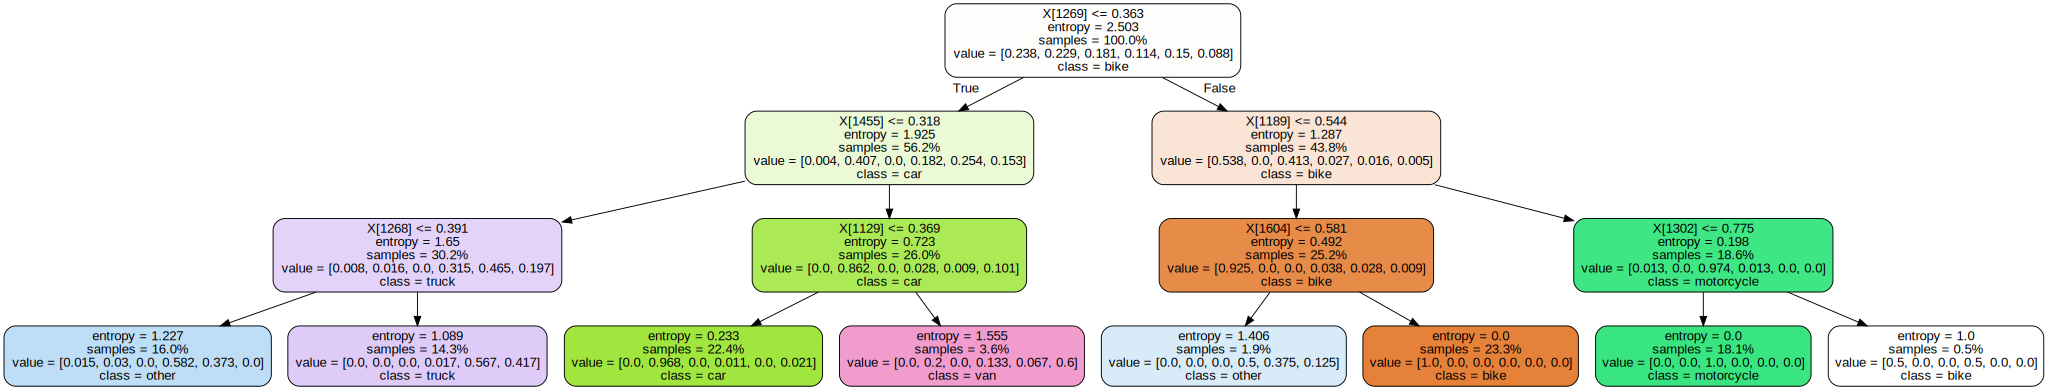

In [32]:
from sklearn.tree import export_graphviz
import graphviz

dt=DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    random_state=0
)

dt.fit(X['trainX'], y['trainX'])

# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    class_names=data['class_name'],
    filled=True, rounded=True, proportion=True   
)

# Display decision tree
graphviz.Source(dot_data)

### Do you get better results if you reduce the number of dimensions with PCA first?

Looking at the results we've got in the GridSearchCV, the best estimator we've got do not use any PCA for dimension reduction (*n_component*=None).

So I will conclude here that reducing the dimension with PCA will not gives us a better result.

But now, what will be the story if we redo our GridSearchCV with this time, different values for the *max_depth* of the DecisionTreeClassifier ?

## *max_depth* as an hyper-parameter of the grid-search

Job is quite simple. We redefine the value of *dt__max_depth* in *dt_grid_param* dict, rebuild a new GridSearchCV, fit it against *trainX* and display results as a *Panda.Dataframe*

In [33]:
# Here are the different parameters I will vary
dt_grid_param['dt__max_depth']=[3, 4, 5, 6, 7, 8, 9, 10]

# Build the GridSearchCV object using versbose and parallel execution options
grid_dt_2=GridSearchCV(dt_pipe, dt_grid_param, cv=CV, refit=True, return_train_score=True, verbose=True, n_jobs=-1, iid=True)

# Fit the model
grid_dt_2.fit(X['trainX'], y['trainX'])

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   48.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=...        min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'dt__criterion': ['gini', 'entropy'], 'dt__max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'pca__n_components': [None, 128, 76, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [34]:
# Display top 5 best test score
columns=[
    'param_dt__criterion', 'param_dt__max_depth', 'param_pca__n_components', 'mean_test_score', 'std_test_score', 'mean_train_score'
]
pd.DataFrame(grid_dt_2.cv_results_).sort_values('mean_test_score', ascending=False)[columns].head(5)


,param_dt__criterion,param_dt__max_depth,param_pca__n_components,mean_test_score,std_test_score,mean_train_score
14,gini,6,76,0.895238,0.038019,0.965479
13,gini,6,128,0.890476,0.049436,0.967860
15,gini,6,16,0.888095,0.043951,0.963686
30,gini,10,76,0.885714,0.037334,0.999408
53,entropy,8,128,0.883333,0.035648,0.999403


Hey, the result is completly different, and PCA dimension reduction is now an option to get a better estimator.

Let's evaluate it.

In [38]:
# Get best estimator
best_dt_2=grid_dt_2.best_estimator_

# Evaluate it against 'test' dataset
accuracy_dt_2=best_dt_2.score(X['test'], y['test'])

# print score
print("DecisionTree_2 score : {:.1f}%".format(accuracy_dt_2*100))


DecisionTree_2 score : 86.0%


Accuracy of our model is now 86%, 6% more that the model with *max_depth=3*

Furthermore, we can see that this time, using a *max_depth=6* and *criterion=gini*, the best results are obtained with *PCA(n_component=76)*

That's a good result and this model is my preferd one I will save on disk, and use it at the end of the project for the overall models evaluation.


In [39]:
# Save model
saveModel(best_dt_2, 'decision-tree')

Saving model decision-tree to model-decision-tree.sav


That's all folks for this Simple Decision Tree classifier :-)